In [92]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
import datetime
now = datetime.datetime.now()
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
    
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ylja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ylja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import datasets


In [2]:
boston15 = pd.read_csv("marathon_results_2015.csv", index_col=0)
boston16 = pd.read_csv("marathon_results_2016.csv", index_col=0)
boston17 = pd.read_csv("marathon_results_2017.csv", index_col=0)

#add variable for the year
boston15['Year'] = 2015
boston16['Year'] = 2016
boston17['Year'] = 2017

#change variable names 
boston15.rename(columns={'M/F':'Sex'}, inplace=True)
boston16.rename(columns={'M/F':'Sex'}, inplace=True)
boston17.rename(columns={'M/F':'Sex'}, inplace=True)

# Preprocessing of the names

In [3]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


boston15['Name']=boston15['Name'].map(lambda s:preprocess(s)) 
boston16['Name']=boston16['Name'].map(lambda s:preprocess(s))
boston17['Name']=boston17['Name'].map(lambda s:preprocess(s))


# Check for repeat runners

In [4]:
merged = pd.concat([boston15,boston16,boston17], sort=False)
merged["Birth"] = merged["Year"]-merged["Age"]

#Create unique identifier
merged.fillna(0, inplace=True)

merged["Id"] = merged["Birth"].astype(str) + "_" + merged["Name"].astype(str) + "_" + merged["Sex"].astype(str) + "_" + merged["Citizen"].astype(str)  
merged['Counts'] = merged.groupby(['Id'])['Year'].transform('count')
merged = merged[merged.Counts < 4]
#merged.to_csv(r"C:\Users\Ylja\OneDrive\Afstuderen\Marcel\output.csv")  # doctest: +SKIP
merged.head()

,Bib,Name,Age,Sex,City,State,Country,Citizen,Unnamed: 9,5K,...,Proj Time,Official Time,Overall,Gender,Division,Year,Unnamed: 8,Birth,Id,Counts
0,3,desisa lelisa,25,M,Ambo,0,ETH,0,0,00:14:43,...,-,02:09:17,1,1,1,2015,0,1990,1990_desisa lelisa_M_0,2
1,4,tsegay yemane adhane,30,M,Addis Ababa,0,ETH,0,0,00:14:43,...,-,02:09:48,2,2,2,2015,0,1985,1985_tsegay yemane adhane_M_0,2
2,8,chebet wilson,29,M,Marakwet,0,KEN,0,0,00:14:43,...,-,02:10:22,3,3,3,2015,0,1986,1986_chebet wilson_M_0,2
3,11,kipyego bernard,28,M,Eldoret,0,KEN,0,0,00:14:43,...,-,02:10:47,4,4,4,2015,0,1987,1987_kipyego bernard_M_0,1
4,10,korir wesley,32,M,Kitale,0,KEN,0,0,00:14:43,...,-,02:10:49,5,5,5,2015,0,1983,1983_korir wesley_M_0,3


# Compare finish times

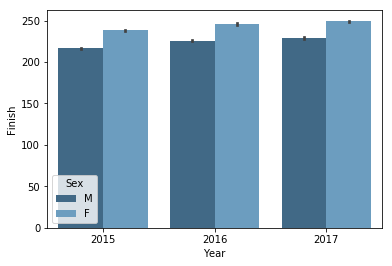

In [95]:
#merged['Finish'] = pd.to_datetime(merged['Official Time'], format='%H:%M:%S').dt.minute
output = pd.read_csv("output.csv", index_col=0, low_memory=False)

#output.boxplot('Finish', by='Year', figsize=(12, 8), showmeans=True)
ax = sns.barplot(x=output["Year"], y=output["Finish"], hue=output["Sex"], data=output, palette="Blues_d")


# Investigate the repeat runners
ANCOVA

F_onewayResult(statistic=156.6239600765373, pvalue=6.722748304968888e-68)

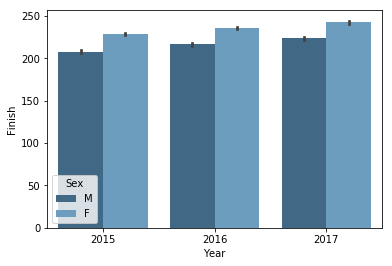

In [114]:
#Only look at the runner who have run 3 years in a row
output = pd.read_csv("output.csv", index_col=0, low_memory=False)
multipleruns = output.loc[output["Counts"]==3]
multipleruns.tail(80)
#multipleruns.boxplot('Finish', by='Year', figsize=(12, 8), showmeans=True)
ax = sns.barplot(x=multipleruns["Year"], y=multipleruns["Finish"], hue=multipleruns["Sex"], data=multipleruns, palette="Blues_d")

#Anova
stats.f_oneway(multipleruns['Finish'][multipleruns['Year'] == 2015], 
             multipleruns['Finish'][multipleruns['Year'] == 2016],
             multipleruns['Finish'][multipleruns['Year'] == 2017])

In [100]:
results = ols('Finish ~ C(Year) + Age + Sex ', data=multipleruns).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Finish   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1028.
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:56:00   Log-Likelihood:                -60875.
No. Observations:               12351   AIC:                         1.218e+05
Df Residuals:                   12346   BIC:                         1.218e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         166.2268      1.350    123.174      0.000     163.582     168.872
C(Year)[T.2016]     6.5759      0.738      8.915      0.000       5.130       8.022
C(Year)[T.2017]    11.9464      0.739     16.155      0.000      10.497      13.396
Sex[T.M]          -25.9444      0.626    -41.463      0.000     -27.171     -24.718
Age                 1.4542      0.028     51.842      0.000       1.399       1.509
==============================================================================
Omnibus:                     4156.932   Durbin-Watson:                   0.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13519.018
Skew:                           1.731   Prob(JB):                         0.00
Kurtosis:                       6.780   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Year),3.157410e+05,2.0,123.872244,5.439740e-54
Age,2.220643e+06,1.0,1742.416221,0.000000e+00
Residual,1.573578e+07,12347.0,NaN,NaN


# Compare the repeat runners to the one time runners per year

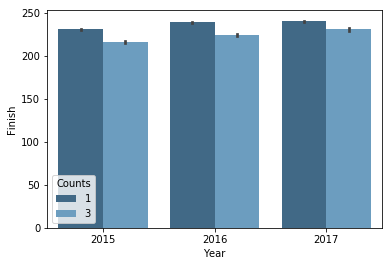

In [124]:
newoutput = output.loc[output["Counts"]!=2]

ax = sns.barplot(x=newoutput["Year"], y=newoutput["Finish"], hue=newoutput["Counts"], data=newoutput, palette="Blues_d")
